In [1]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm

In [2]:
key = jax.random.PRNGKey(5)

## 1. Problem Initialisation
In this notebook we demonstrate the entire conductivity inference process. One starts with defining a conductivity k which later has to be inferred and takes multiple measurements of it. This means creating a list of (dirichlet, neumann) boundary value pairs which are satisfied by the conductivity k.

### Chebyshev Solver
The chebyshev solver allows the evaluation of a function $f$ which calculates the neumann boundaries (heat current) of the temperature field given
a cunductivity $k$ and dirichlet boundaries:
$$
\mathrm{neumann} = \mathrm{solve}(k, \mathrm{dirichlet})
$$

In [15]:
#
# Set up the solver
#

solver = chb.Solver(N = 20)     # the chebyshev solver
xx = solver.xx                  # the x coordinate grid
yy = solver.yy                  # the y coordinate grid
grid = solver.grid              # the grid
dims = (solver.N, solver.N)     # the shape of the field representation
mask = np.ones(dims)            # a mask to set all the internal values of a scalar field to zero
mask[1:-1,1:-1] = 0             # used to generate dirichlet bundaries
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))   # this is an multiplicative overlay to make chebyshev coefficients to decay exponentially
a = 1.2                                                             # decay coefficient
index_decay = jnp.exp(-(ii+jj)/a)



#
# generate conductivity k to infer
#

k_cheby_init = jax.random.normal(key, shape = dims) * index_decay                   # sample random normal coefficients and make them decay
k_cheby_init = k_cheby_init.at[0,0].set(k_cheby_init[0,0] + jnp.sum(index_decay)*2) # add to the zeroth coefficient to make k positive
k_cheby_init = k_cheby_init.flatten()
k_init = (solver.I @ k_cheby_init).reshape(dims)                                    # transform k into physical space



#
# Generate measurements
#
N_measure = 15          # number of measurements
measurements = []
for i in range(N_measure):
    key, _ = jax.random.split(key)

    dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay        # create a random scalar field
    dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
    dirichlet *= mask                                                           # mask the internal values of the scalar field

    sol = solver.solve(k_cheby_init, dirichlet)                                 # solve the heat equation for initial k and generated dirichlet condition

    measurements.append((dirichlet, sol))


#
# Calculate the von neumann boundaries for a given temperature
#

@jax.jit
def get_neumann(solution):
    """
    calculates the neumann boundaries given the output of the chebyshev solver.
    It returns an shape = (4N,) array of the boundary values of the heat current
    """
    jx = (solution["dx T"] * solution["k"]).reshape(dims)
    jy = (solution["dy T"] * solution["k"]).reshape(dims)

    neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
    return neumann

#
# Define a distance function comparing different von neumann boundaries.
#

@jax.jit
def distance(solution, target_solution):
    """
    Given two outputs of the chebyshev solver, calculates the distance between two neumann boundaries.
    """
    neumann = get_neumann(solution)
    target_neumann = get_neumann(target_solution)

    return jnp.sum((neumann - target_neumann)**2)

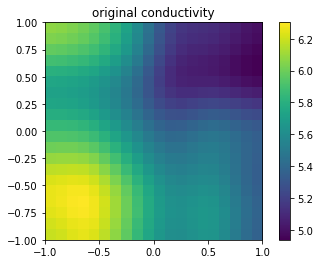

In [20]:
#
# conductivity to infer:
#

plt.imshow(k_init, extent = [-1,1,-1,1])
plt.colorbar()
plt.title("original conductivity")
plt.savefig("../plot/conductivity.pdf")

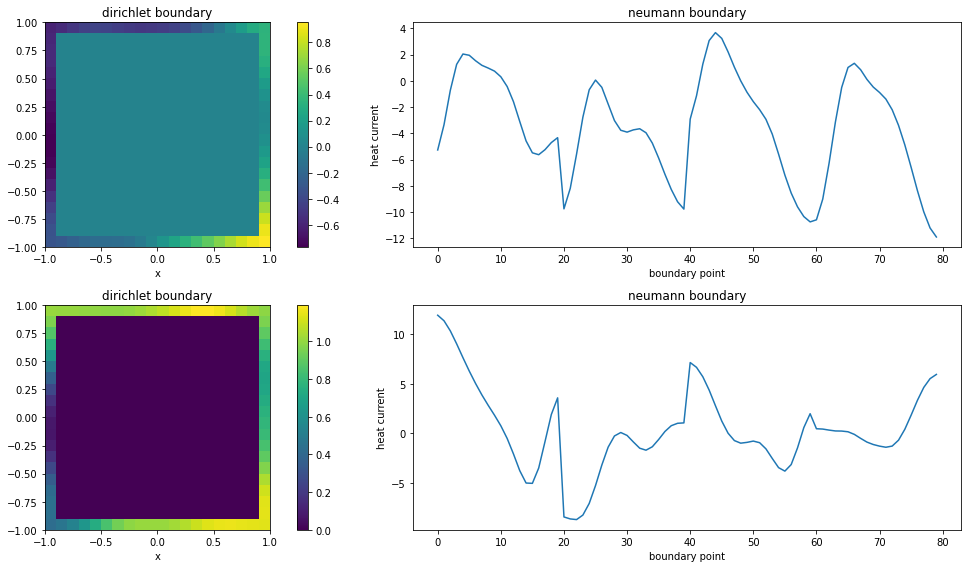

In [21]:
#
# Plot the measurements (only the first two)
#

fig, axs = plt.subplots(2, 2, figsize = (16,8))
for i in range(2):
    im1 = axs[i,0].imshow((measurements[i][1]["T"].reshape(dims) * mask), extent = [-1,1,-1,1])
    plt.colorbar(im1, ax = axs[i,0])
    axs[i,0].set_title("dirichlet boundary")
    axs[i,0].set_xlabel("x")
    axs[i,1].set_ylabel("y")
    im2 = axs[i,1].plot(get_neumann(measurements[i][1]))
    axs[i,1].set_title("neumann boundary")
    axs[i,1].set_xlabel("boundary point")
    axs[i,1].set_ylabel("heat current")
    

fig.tight_layout()
plt.savefig("../plot/measurements.pdf")

## 2. Initialise variational Parameters

In [22]:
#
# initialise a random k guess in chebyshev space
#

key, _ = jax.random.split(key)                                  # we randomly sample chebyshev coefficients
                                                                # and make them decay for out initial guess
k_cheby = jax.random.normal(key, shape = dims) * index_decay
k_cheby = k_cheby.at[0,0].set(k_cheby[0,0] + jnp.sum(index_decay))

k_param = {"coeff":k_cheby}                                     # store the parameters of the k field

In [23]:
#
# helper functions
#

@jax.jit
def get_solution(k_param, dirichlet):
    """
    given the parameters, this function generates an admissable conductivity k (by making coefficients decay)
    and computes the output if the chebyshev solver.
    """
    k_cheby = k_param["coeff"] * index_decay
    k_cheby = k_cheby.flatten()
    solution = solver.solve(k_cheby, dirichlet)
    return solution


@jax.jit
def get_solution_internal(k_cheby_flat, dirichlet):
    """
    an internal help function which enables automatic computation of a hessian (not used somewhere else)
    """
    solution = solver.solve(k_cheby_flat, dirichlet)
    return solution

## 3. Optimize Parameters
Given the measurements $(\mathrm{dirichlet}_i,\mathrm{neumann}_i)$ one can calulate a loss for a proposed conductivity:
$$
L(k) = \sum_{i} || neumann_i - solve(k, dirichlet_i) ||^2
$$
We optimise this loss by gradient descent.

In [24]:
@jax.jit
def loss(k_param):
    """
    Loss function. Sums the squared distance of the resulting differences of neumann boundaries for given parametrisation of k.
    """
    acc = 0
    for i in range(N_measure):
        acc += distance(get_solution(k_param, measurements[i][0]), measurements[i][1])
    return acc

@jax.jit
def loss_internal(k_cheby_flat):
    """
    Internal help function which allows for hessian computation.
    """
    acc = 0
    for i in range(N_measure):
        acc += distance(get_solution_internal(k_cheby_flat, measurements[i][0]), measurements[i][1])
    return acc

g = jax.value_and_grad(loss)
h = jax.hessian(loss_internal)

In [25]:
# define
optimizer = optax.sgd(learning_rate=0.0003)    # initialise a stochastic gradient descent optimiser

# initialise
optimizer_state = optimizer.init(k_param)

err = []                                        # record the statistics

In [26]:
######################
# Optimisation Loop
######################

for i in tqdm(range(4000)):
    val, grad = g(k_param)
    err.append(val)

    updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

    k_param = optax.apply_updates(k_param, updates)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [30:29<00:00,  2.19it/s]


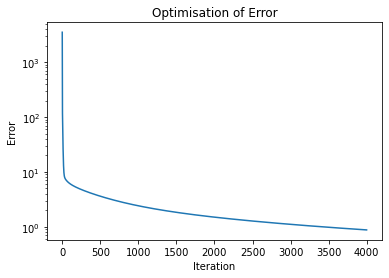

In [37]:
plt.plot(err)
plt.yscale("log")
plt.title("Optimisation of Error")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.savefig("../plot/optimisation.pdf")

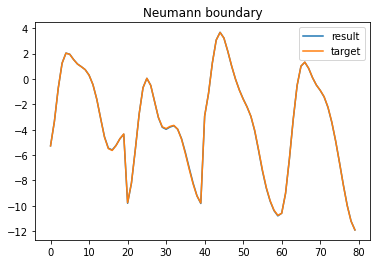

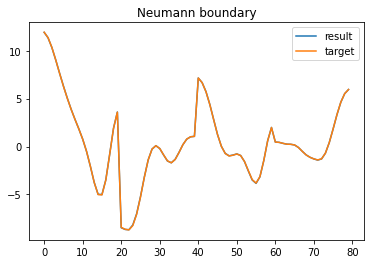

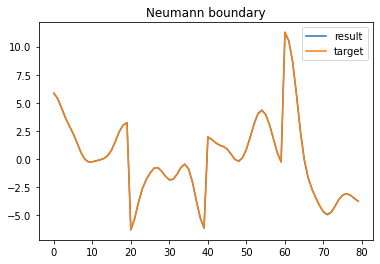

In [28]:
#
# This shows the agreeing neumann boundaries resulting from optimised guess and initial k.
#

for i in range(3):
    plt.figure()
    plt.plot(get_neumann(get_solution(k_param, measurements[i][0])), label = "result")
    plt.plot(get_neumann(measurements[i][1]), label ="target")

    plt.legend()
    plt.title("Neumann boundary")

<Figure size 432x288 with 0 Axes>

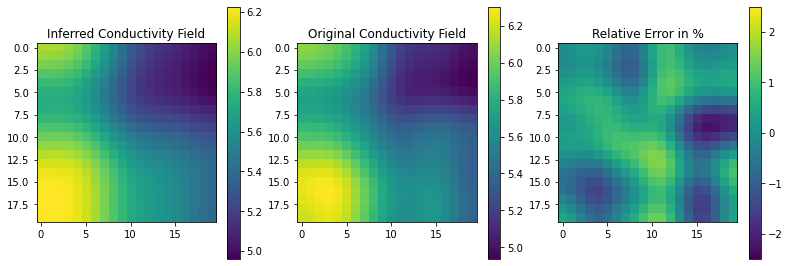

In [34]:
for i in range(1):
    plt.figure()
    result = get_solution(k_param, measurements[i][0])
    fig, axs = plt.subplots(1, 3, figsize = (11,3.8))
    im1 = axs[0].imshow(result["k"].reshape(dims))
    axs[0].set_title("Inferred Conductivity Field")
    im2 = axs[1].imshow(measurements[i][1]["k"].reshape(dims))
    axs[1].set_title("Original Conductivity Field")

    im3 = axs[2].imshow((result["k"].reshape(dims) / (measurements[i][1]["k"].reshape(dims))-1)*100, vmin = -0.025*100, vmax = 0.025*100)
    axs[2].set_title("Relative Error in %")
    
    plt.colorbar(im1, ax = axs[0])
    plt.colorbar(im2, ax = axs[1])
    plt.colorbar(im3, ax = axs[2])
fig.tight_layout()   
plt.savefig("../plot/Inferred20x20_new.pdf")

In [35]:
# computes the gridpoint-maximum relative error of the conductivity

jnp.max(jnp.abs(result["k"].reshape(dims) / (measurements[i][1]["k"].reshape(dims)) - 1)) * 100

Array(2.26119065, dtype=float64)

In [36]:
## computes the averaged relative error of the conductivity

jnp.mean(jnp.abs(result["k"].reshape(dims) / (measurements[i][1]["k"].reshape(dims)) - 1)) * 100

Array(0.66040771, dtype=float64)

## Hessian

In [38]:
lambd, vec = jnp.linalg.eigh(h(k_param["coeff"].flatten()))

Text(0.5, 1.0, 'Eigenvalues of Hessian')

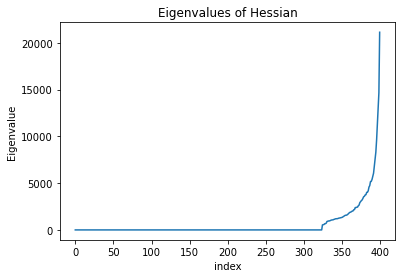

In [39]:
## we plot the spectrum of the Hessian and see that it is positive.

plt.plot(lambd)
plt.xlabel("index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of Hessian")

---